#### A year's worth of sales from a fictitious pizza place, including the date and time of each order and the pizzas served, with additional details on the type, size, quantity, price, and ingredients.

Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pyodbc

Connection SQL

In [2]:
server = "DESKTOP-QFEDT35"
database = "pizza_sales"
trusted_connection = "yes"

# Connection string(Windows Authentication)
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection={trusted_connection};"
)

try:
    conn = pyodbc.connect(connection_string)
    print("Connected to database successfully")
except pyodbc.Error as e:
    print("Error connecting to database:", e)

Connected to database successfully


Read Data

In [3]:
query = """
select
    o.order_id,
    o.date, 
    cast(o.time as time(0)) as time,
    pt.name, 
    pt.category, 
    p.size, 
    p.price as price_unit, 
    od.quantity 
from order_details_r od 
join orders_r o on od.order_id = o.order_id 
join pizzas_r p on od.pizza_id = p.pizza_id 
join pizza_types_r pt on pt.pizza_type_id = p.pizza_type_id;
"""

df = pd.read_sql_query(query, conn)
df.head()

C:\Users\Farzah\AppData\Local\Temp\ipykernel_10112\4179984347.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,order_id,date,time,name,category,size,price_unit,quantity
0,1,2015-01-01,11:38:36,The Hawaiian Pizza,Classic,M,1325.0,1
1,2,2015-01-01,11:57:40,The Classic Deluxe Pizza,Classic,M,16.0,1
2,2,2015-01-01,11:57:40,The Five Cheese Pizza,Veggie,L,185.0,1
3,2,2015-01-01,11:57:40,The Italian Supreme Pizza,Supreme,L,2075.0,1
4,2,2015-01-01,11:57:40,The Mexicana Pizza,Veggie,M,16.0,1


Check Row and Columns of Dataset

In [4]:
print(f"Rows Data : {df.shape[0]}")
print(f"Columns Data : {df.shape[1]}")

Rows Data : 48620
Columns Data : 8


Check Type Data

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    48620 non-null  int64  
 1   date        48620 non-null  object 
 2   time        48620 non-null  object 
 3   name        48620 non-null  str    
 4   category    48620 non-null  str    
 5   size        48620 non-null  str    
 6   price_unit  48620 non-null  float64
 7   quantity    48620 non-null  int64  
dtypes: float64(1), int64(2), object(2), str(3)
memory usage: 3.0+ MB


In [6]:
df.describe()

,order_id,price_unit,quantity
count,48620.000000,48620.000000,48620.000000
mean,10701.479761,955.201851,1.019622
std,6180.119770,880.919175,0.143077
min,1.000000,11.000000,1.000000
25%,5337.000000,125.000000,1.000000
50%,10682.500000,975.000000,1.000000
75%,16100.000000,2025.000000,1.000000
max,21350.000000,3595.000000,4.000000


Check Missing Values

In [7]:
print(f"Missing Values\n{df.isnull().sum()}")

Missing Values
order_id      0
date          0
time          0
name          0
category      0
size          0
price_unit    0
quantity      0
dtype: int64


Check Duplicated Values

In [8]:
print(f"Duplicated Values : {df.duplicated().sum()}")

Duplicated Values : 0


Split Features Into Numerical and Categorical

In [9]:
numerical_features = df.select_dtypes(include="number").columns
categorical_features = df.select_dtypes(include="str").columns
print(f"Numerical Features : {", ".join(list(numerical_features))}")
print(f"Categorical Features : {", ".join(list(categorical_features))}")

Numerical Features : order_id, price_unit, quantity
Categorical Features : name, category, size


In [10]:
df["total_price"] = df["price_unit"] * df["quantity"]

Check Outliers

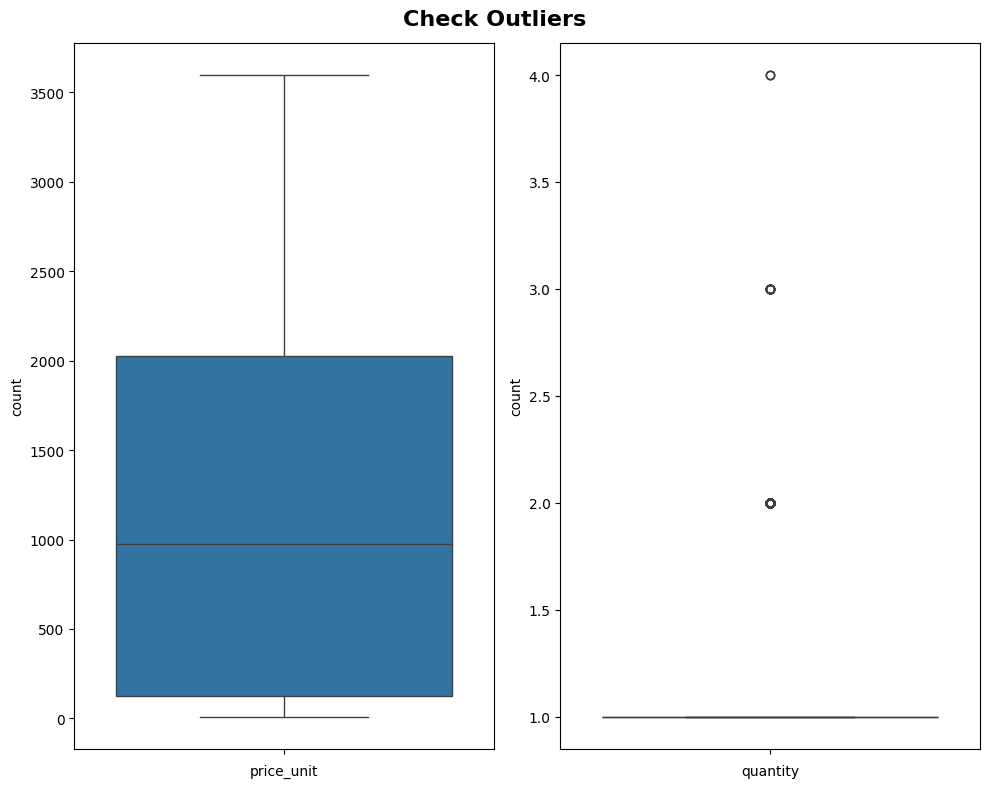

In [11]:
cols = ["price_unit", "quantity"]
plt.figure(figsize=(10,8))
plt.suptitle("Check Outliers", fontsize=16, fontweight="bold")
for i, col in enumerate(cols):
    plt.subplot(1,2,i+1)
    sns.boxplot(y=df[col])
    plt.xlabel(col)
    plt.ylabel("count")
plt.tight_layout()
plt.show()


Calculate pizza sales by Category and Size

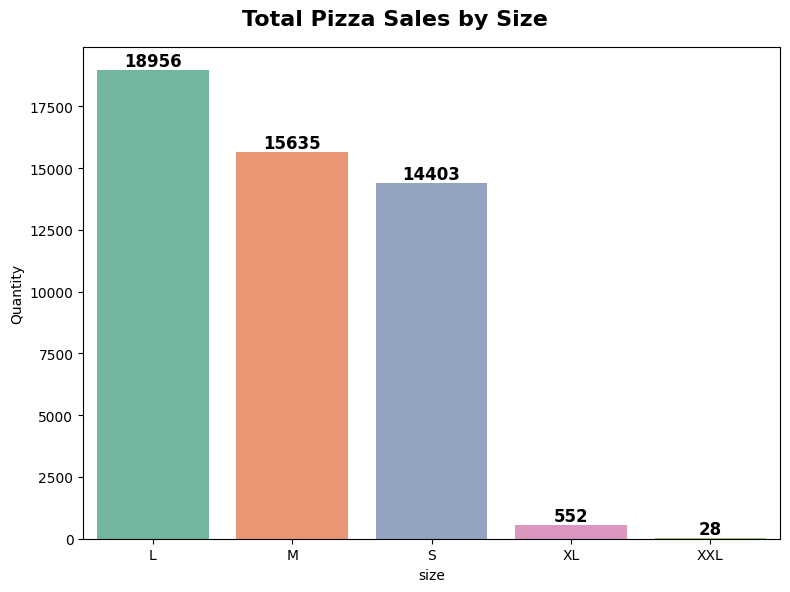

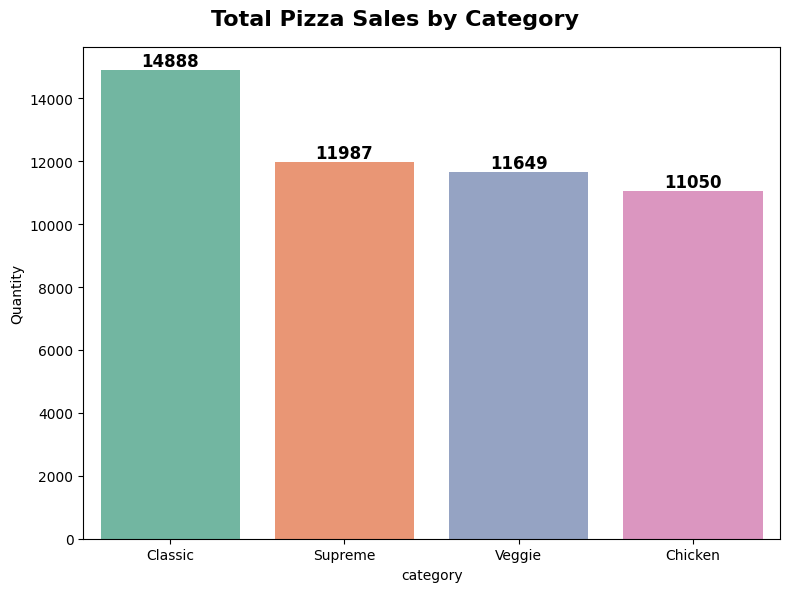

In [12]:
cols = ["size", "category"]
for i, col in enumerate(cols):
    total_category_size = df.groupby(col)["quantity"].sum().sort_values(ascending=False)
    plt.figure(figsize=(8,6 ))
    plt.suptitle(f"Total Pizza Sales by {col.capitalize()}", fontsize=16, fontweight="bold")
    ax = sns.barplot(
        x=total_category_size.index,
        y=total_category_size.values,
        hue=total_category_size.index,
        palette="Set2"
    )
    for data in ax.containers:
        ax.bar_label(
            data,
            fontsize=12,
            fontweight="bold",
            color="black",
            label_type="edge"
        )
    plt.xlabel(col)
    plt.ylabel("Quantity")
    plt.tight_layout()
    plt.show()

Which month has the most Revenue and most Total Orders?

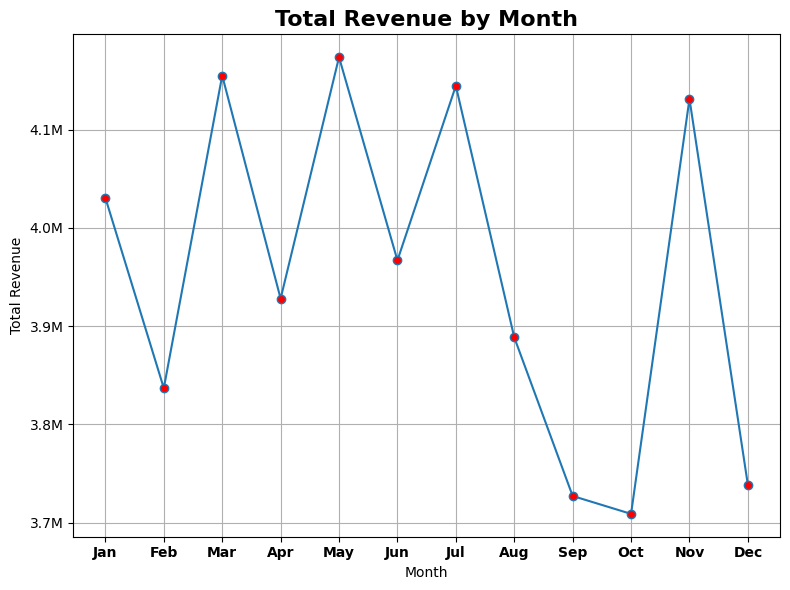

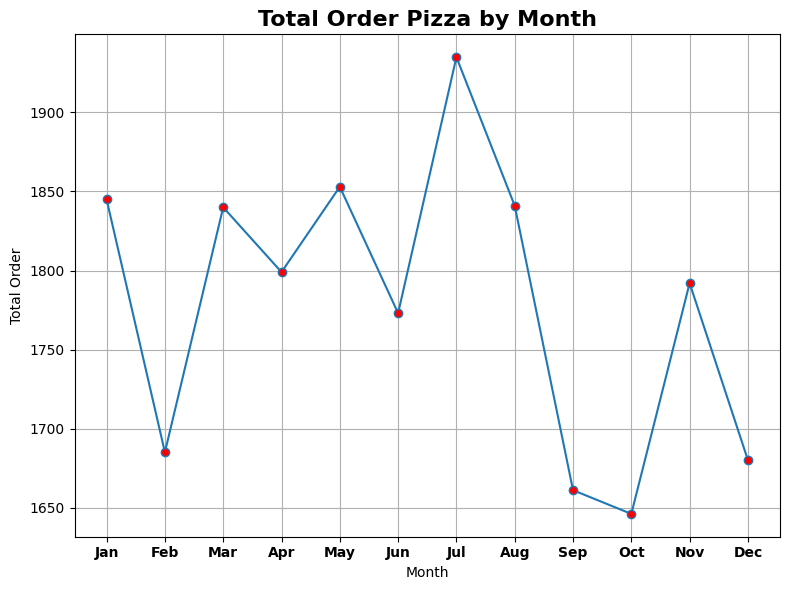

In [13]:
df["date"] = pd.to_datetime(df["date"])
month = df["date"].dt.month
name_month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Total Revenue
total_revenue_by_month = df.groupby(month)["total_price"].sum().sort_index()
total_revenue_by_month.index = name_month

plt.figure(figsize=(8,6))
plt.title("Total Revenue by Month", fontsize=16, fontweight="bold")
ax = plt.gca()
plt.plot(
    total_revenue_by_month.index, 
    total_revenue_by_month.values, 
    marker="o", 
    markerfacecolor='red'
)
# Formatter for values total revenue
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x/1e6:.1f}M"))
plt.xticks(total_revenue_by_month.index, fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.tight_layout()          
plt.show()

# Total Order
month = df["date"].dt.month
total_order_by_month = df.groupby(month)["order_id"].nunique().sort_index() ##count nunique values
total_order_by_month.index = name_month

plt.figure(figsize=(8,6))
plt.title("Total Order Pizza by Month", fontsize=16, fontweight="bold")
plt.plot(
    total_order_by_month.index, 
    total_order_by_month.values, 
    marker="o", 
    markerfacecolor='red'
)
plt.xticks(total_order_by_month.index, fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Total Order")
plt.grid(True)
plt.tight_layout()          
plt.show()

How many pizzas are typically in an order? Do we have any bestsellers?

Average number of pizzas per order: 2.32


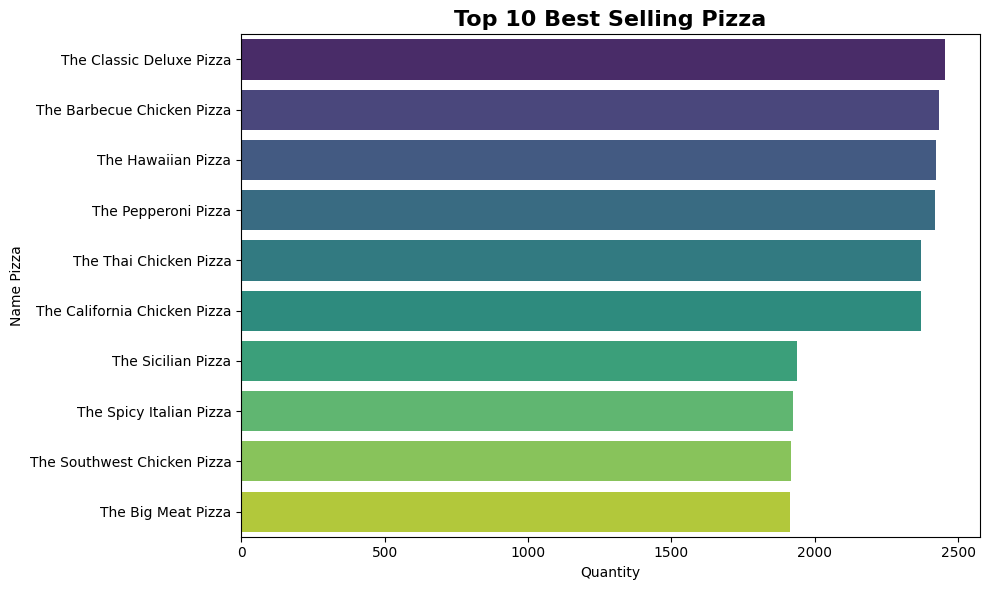

In [14]:
# Calculate average number of pizzas per order
avg_pizzas_per_order = df.groupby("order_id")["quantity"].sum().mean()
print(f"Average number of pizzas per order: {avg_pizzas_per_order:.2f}")

# Find best-selling pizzas
bestsellers = df.groupby("name")["quantity"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.title("Top 10 Best Selling Pizza", fontsize=16, fontweight="bold")
sns.barplot(
    y=bestsellers.index, 
    x=bestsellers.values, 
    hue=bestsellers.index, 
    palette="viridis"
)
plt.xlabel("Quantity")
plt.ylabel("Name Pizza")
plt.tight_layout()
plt.show()

How many Order Per Day do we have each day? Are there any peak hours?

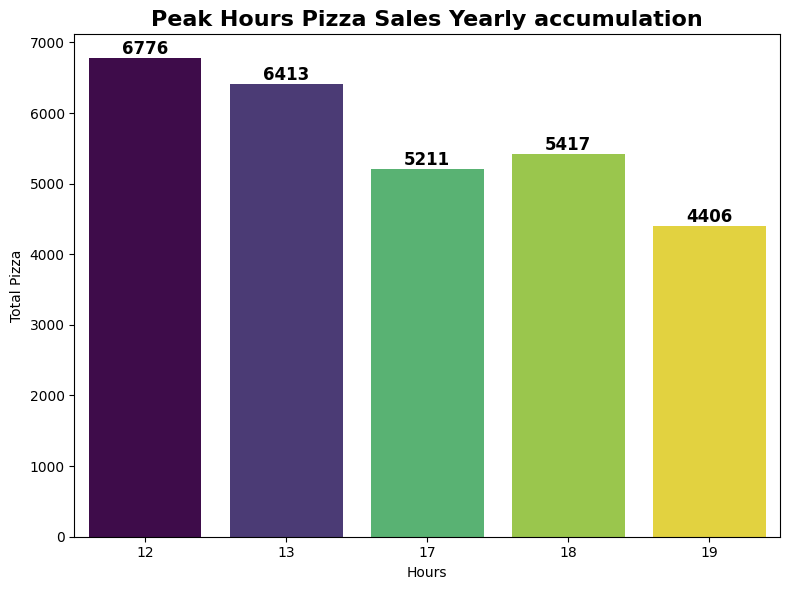

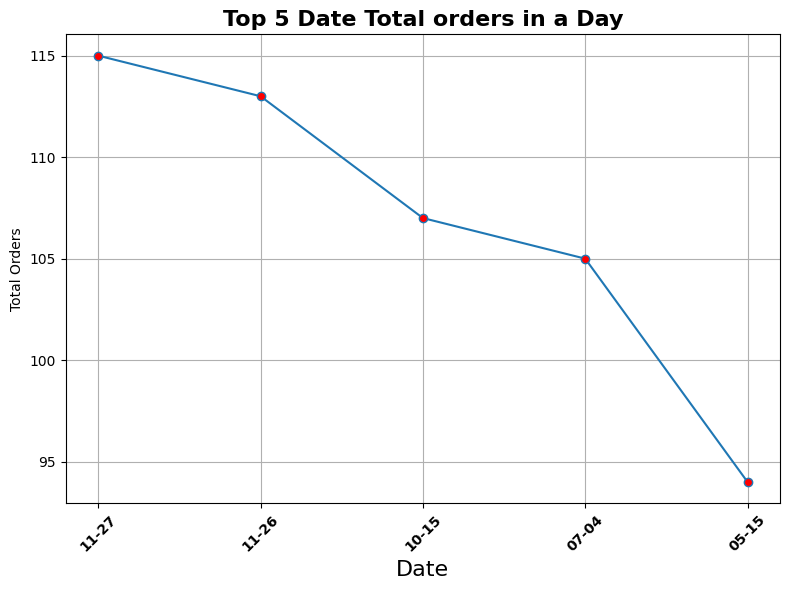

In [ ]:
# Peak Hours
hour = pd.to_datetime(df["time"], format="%H:%M:%S").dt.hour
time_sales_pizza = df.groupby(hour)["quantity"].sum().sort_values(ascending=False).head()
plt.figure(figsize=(8,6))
plt.title("Peak Hours Pizza Sales Yearly Accumulation", fontsize=16, fontweight="bold")
ax = sns.barplot(
    x=time_sales_pizza.index, 
    y=time_sales_pizza.values, 
    hue=time_sales_pizza.index, 
    palette="viridis"
)
for data in ax.containers:
    ax.bar_label(
        data,
        fontsize=12,
        fontweight="bold",
        color="black",
        label_type="edge"
    )
plt.xlabel("Hours")
plt.ylabel("Total Pizza")
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()


# Date Total Order
date = df["date"].dt.date
total_order = df.groupby(date)["order_id"].nunique().sort_values(ascending=False).head()
total_order.index = [d.strftime('%m-%d') for d in total_order.index]
plt.figure(figsize=(8,6))
plt.title("Top 5 Date Total orders in a Day", fontsize=16, fontweight="bold")
plt.plot(
    total_order.index, 
    total_order.values,
    marker="o",
    markerfacecolor="red"
)
plt.xticks(total_order.index, fontweight="bold")
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Total Orders")
plt.grid(True)
plt.tight_layout()          
plt.show()

Which pizza has the highest revenue?

In [16]:
total_sales = df.groupby(["name", "size", "category"])["total_price"].sum().sort_values(ascending=False)
best_selling_pizza = total_sales.reset_index().rename(columns={0:"total revenue"}).head()
best_selling_pizza

,name,size,category,total_price
0,The Thai Chicken Pizza,L,Chicken,2925750.0
1,The Four Cheese Pizza,L,Veggie,2362220.0
2,The Spicy Italian Pizza,L,Supreme,2301175.0
3,The Southwest Chicken Pizza,L,Chicken,2108200.0
4,The Barbecue Chicken Pizza,L,Chicken,2058400.0


Which Size and Category has the most revenue?

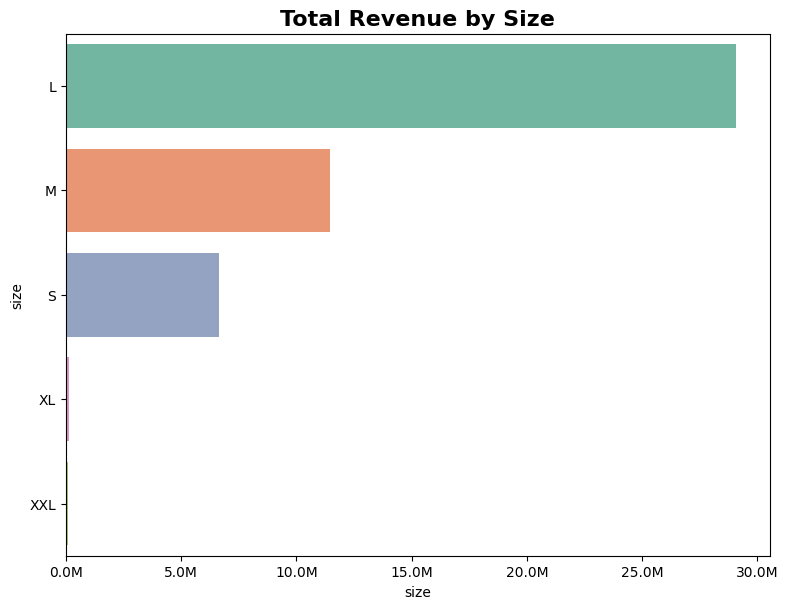

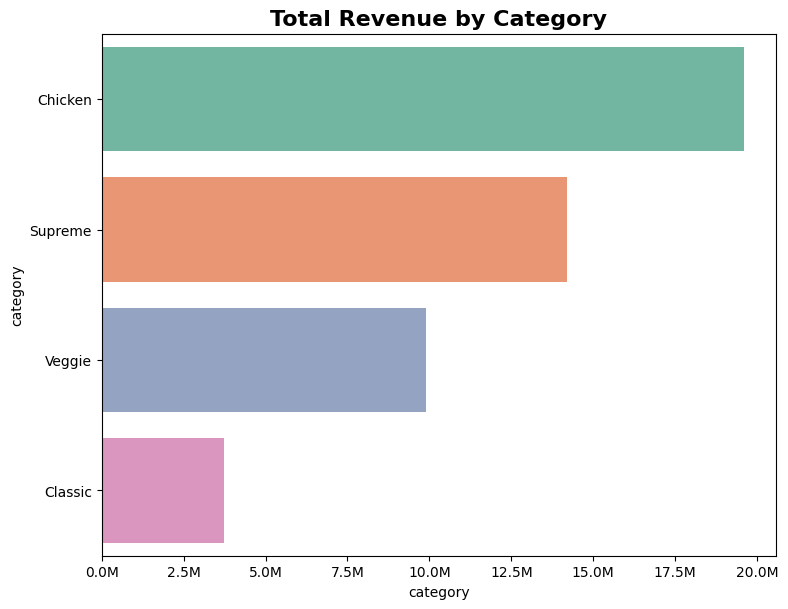

In [17]:
cols=["size", "category"]

for col in cols:
    revenue_by_cols = df.groupby(col)["total_price"].sum().sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    plt.title(f"Total Revenue by {col.capitalize()}", fontsize=16, fontweight="bold")
    ax = sns.barplot(
        x=revenue_by_cols.values,
        y=revenue_by_cols.index,
        hue=revenue_by_cols.index,
        palette="Set2"
    )
    # Formatter for values total revenue
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x/1e6:.1f}M"))
    plt.tight_layout()
    plt.xlabel("Revenue")
    plt.xlabel(col)
    plt.show()

How much money did we make this year? 

In [18]:
total_revenue = df["total_price"].sum()
print(f"Total revenue in the year: ${total_revenue:,}")

Total revenue in the year: $47,429,918.0


Correlation between Price Unit and Quantity

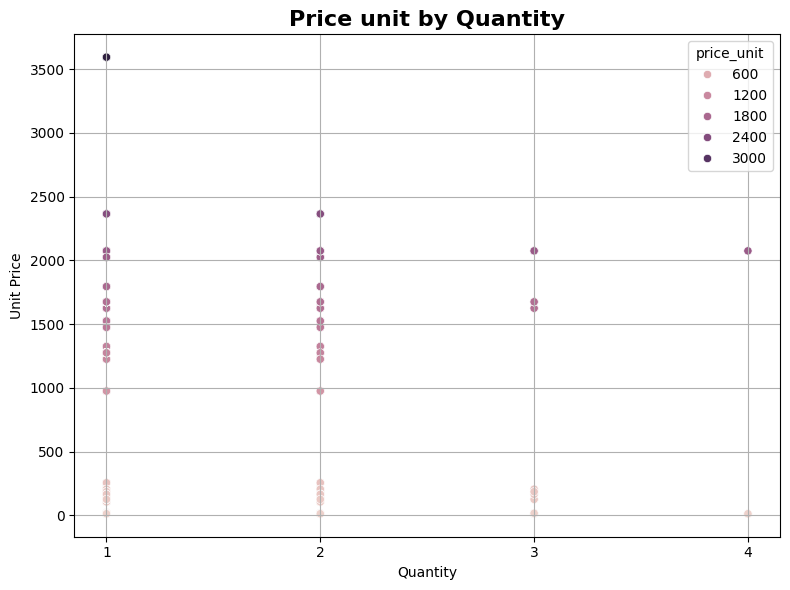

In [19]:
plt.figure(figsize=(8,6))
plt.title("Price unit by Quantity", fontsize=16, fontweight="bold")
sns.scatterplot(data=df, x="quantity", y="price_unit", hue="price_unit")
plt.xlabel("Quantity")
plt.ylabel("Unit Price")
plt.xticks(df["quantity"].unique())
plt.grid(True)
plt.tight_layout()
plt.show()

Correlation

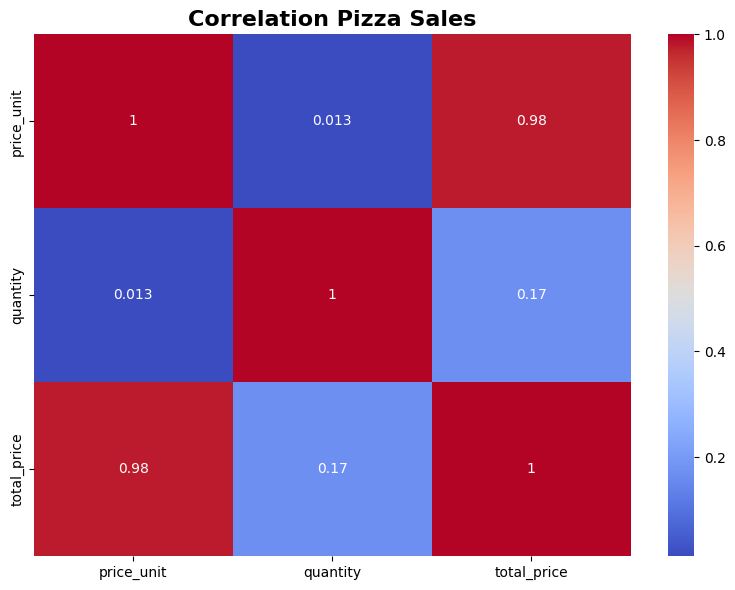

In [20]:
cols = ["price_unit", "quantity", "total_price"]
correlation = df[cols].corr()

plt.figure(figsize=(8,6))
plt.title("Correlation Pizza Sales", fontsize=16, fontweight="bold")
sns.heatmap(correlation, annot=True, fmt=".2g", cmap="coolwarm")
plt.tight_layout()
plt.show()

Export to CSV

In [21]:
name_file = "final_dataset_pizza"
export = df.to_csv(f"{name_file}.csv", index=False)
print(f"Successfully Export {name_file}")

Successfully Export final_dataset_pizza


### Insight
From the analysis above, it can be concluded that in a year the total pizza orders are highest based on the month, namely July. For peak hours more often during the day/break time, it is recommended for managers/owners to manage so that employees with those hours are already many because those hours are peak hours. For pizza business owners, it is better to remove the XXL pizza size because it is less popular, they prefer standard sizes such as M, and L because of the cheap price. In this year, the highest revenue occurred in the 2nd Quarter and a slight decrease in revenue in the 4th Quarter. And if possible, the owner/manager of the business should add stock for the CLASSIC pizza category because it is popular.